In [1]:
import numpy as np
import torch
# At the start of your notebook
from IPython.display import clear_output
import gc

# After heavy computations
clear_output(wait=True)
gc.collect()

0

In [2]:
from steps import setup_and_train_models, analyze_seizure_propagation

In [3]:
RESULT_FOLDER = "result"
MODEL_FOLDER = "model"
model_names = ['Wavenet2']  # 'CNN1D', 'Wavenet', 'LSTM'

In [4]:
# Do batch analysis to find the best hyperparameters
seizures = [1, 2, 3, 5, 7]
thresholds = [0.8]
smooth_windows = [80]

In [5]:
results, models = setup_and_train_models(
    data_folder="data",
    model_folder="checkpoints",
    model_names=model_names,  # Only use CNN1D and Wavenet
    train=True,
    params={'epochs': 60, 'batch_size': 4096}
)

Removed 0 zero-padded samples out of 143136 total samples
Using 143136 samples from each class for balanced dataset
Final dataset shapes - Training: (229017, 1, 128), Validation: (57255, 1, 128)
Removed 0 zero-padded samples out of 21056 total samples
Using 21056 samples from each class for balanced dataset
Final dataset shapes - Training: (33689, 1, 128), Validation: (8423, 1, 128)
Removed 29570 zero-padded samples out of 225000 total samples
Using 98000 samples from each class for balanced dataset
Final dataset shapes - Training: (156800, 1, 128), Validation: (39200, 1, 128)

Training Wavenet2...


Epoch 5/60: 100%|██████████| 103/103 [00:09<00:00, 10.34it/s, loss=0.5638, avg_loss=0.5711]


Epoch [5/60]
Training Loss: 0.5711
Validation Loss: 0.5640
Validation Accuracy: 0.7228


Epoch 10/60: 100%|██████████| 103/103 [00:10<00:00, 10.14it/s, loss=0.5580, avg_loss=0.5485]


Epoch [10/60]
Training Loss: 0.5485
Validation Loss: 0.5414
Validation Accuracy: 0.7513


Epoch 15/60: 100%|██████████| 103/103 [00:10<00:00, 10.24it/s, loss=0.5333, avg_loss=0.5342]


Epoch [15/60]
Training Loss: 0.5342
Validation Loss: 0.5339
Validation Accuracy: 0.7589


Epoch 20/60: 100%|██████████| 103/103 [00:09<00:00, 10.35it/s, loss=0.5237, avg_loss=0.5260]


Epoch [20/60]
Training Loss: 0.5260
Validation Loss: 0.5222
Validation Accuracy: 0.7745


Epoch 25/60: 100%|██████████| 103/103 [00:10<00:00, 10.10it/s, loss=0.5239, avg_loss=0.5186]


Epoch [25/60]
Training Loss: 0.5186
Validation Loss: 0.5164
Validation Accuracy: 0.7806


Epoch 30/60: 100%|██████████| 103/103 [00:10<00:00, 10.07it/s, loss=0.5177, avg_loss=0.5120]


Epoch [30/60]
Training Loss: 0.5120
Validation Loss: 0.5128
Validation Accuracy: 0.7856


Epoch 35/60: 100%|██████████| 103/103 [00:09<00:00, 10.41it/s, loss=0.5118, avg_loss=0.5063]


Epoch [35/60]
Training Loss: 0.5063
Validation Loss: 0.5091
Validation Accuracy: 0.7888


Epoch 40/60: 100%|██████████| 103/103 [00:10<00:00,  9.98it/s, loss=0.4943, avg_loss=0.4990]


Epoch [40/60]
Training Loss: 0.4990
Validation Loss: 0.5080
Validation Accuracy: 0.7908


Epoch 45/60: 100%|██████████| 103/103 [00:10<00:00,  9.84it/s, loss=0.4792, avg_loss=0.4938]


Epoch [45/60]
Training Loss: 0.4938
Validation Loss: 0.5019
Validation Accuracy: 0.7994


Epoch 50/60: 100%|██████████| 103/103 [00:10<00:00, 10.14it/s, loss=0.4874, avg_loss=0.4885]


Epoch [50/60]
Training Loss: 0.4885
Validation Loss: 0.4979
Validation Accuracy: 0.8032


Epoch 55/60: 100%|██████████| 103/103 [00:10<00:00, 10.20it/s, loss=0.4885, avg_loss=0.4826]


Epoch [55/60]
Training Loss: 0.4826
Validation Loss: 0.4934
Validation Accuracy: 0.8088


Epoch 60/60: 100%|██████████| 103/103 [00:10<00:00, 10.19it/s, loss=0.4824, avg_loss=0.4780]


Epoch [60/60]
Training Loss: 0.4780
Validation Loss: 0.4916
Validation Accuracy: 0.8106


In [6]:
results_propagation_total = []
model_name = 'Wavenet2'
model = models[model_name]
threshold = 0.8
smooth_window = 80
for PAT_NO in [65, 66]:
    for seizure_no in seizures:
        if PAT_NO == 66 and seizure_no > 3:
            continue
        params = {
            'threshold': threshold,
            'smooth_window': smooth_window,
            'n_seconds': 60,
            'seizure_start': 10,
        }
        results_propagation = analyze_seizure_propagation(
            patient_no=PAT_NO,
            seizure_no=seizure_no,
            model=model,
            data_folder='data',
            params=params,
            save_results_ind=True
        )
        results_propagation_total.append(results_propagation)

Results saved to: result\P65\Seizure1\analysis_results
Results saved to: result\P65\Seizure2\analysis_results
Results saved to: result\P65\Seizure3\analysis_results
Results saved to: result\P65\Seizure5\analysis_results
Results saved to: result\P65\Seizure7\analysis_results
Results saved to: result\P66\Seizure1\analysis_results
Results saved to: result\P66\Seizure2\analysis_results
Results saved to: result\P66\Seizure3\analysis_results


In [7]:
import torch
from torch.utils.data import DataLoader
from datasetConstruct import CustomDataset, load_seizure_across_patients, create_dataset, combine_loaders
from sklearn.model_selection import StratifiedShuffleSplit


In [8]:
def prepare_data(data_folder: str, batch_size: int):
    """Prepare datasets and dataloaders"""
    seizure_across_patients = load_seizure_across_patients(data_folder)
    ml_datasets = [create_dataset(seizure, batch_size=batch_size)
                   for seizure in seizure_across_patients]
    train_loader, val_loader = combine_loaders(ml_datasets, batch_size=batch_size)
    channels, time_steps = train_loader.dataset[0][0].shape
    return train_loader, val_loader, channels, time_steps

In [9]:
def construct_channel_recognition_dataset(results_propagation_total, seizure_onset_window_size=60, batch_size=64, split=0.8):
    def construct_single_dataset(results_propagation, window_size):
        # Add print statements to debug sizes
        x = results_propagation['smoothed_probabilities'][50:window_size*5+50, :]
        
        y = np.zeros(x.shape[1])
        y[results_propagation['true_seizure_channels']] = 1
        
        return x, y, x, y
    
    x_total = []
    y_total = []
    x_onset_total = []
    y_onset_total = []
    
    for i, results_propagation in enumerate(results_propagation_total):
        x, y, x_onset, y_onset = construct_single_dataset(results_propagation, seizure_onset_window_size)
        x_total.append(x)
        y_total.append(y)
        x_onset_total.append(x_onset)
        y_onset_total.append(y_onset)
    
    # Concatenate and transpose
    x_total = np.concatenate(x_total, axis=1).T
    
    # Add channel dimension
    x_total = np.expand_dims(x_total, axis=1)
    
    # Convert to tensor and split
    y_total = np.concatenate(y_total)
    
    # Get balanced dataset
    positive_indices = np.where(y_total == 1)[0]
    negative_indices = np.where(y_total == 0)[0]
    
    # Get the same number of positive and negative samples
    n_samples = min(len(positive_indices), len(negative_indices))
    
    positive_indices = np.random.choice(positive_indices, n_samples, replace=False)
    negative_indices = np.random.choice(negative_indices, n_samples, replace=False)
    
    indices = np.concatenate([positive_indices, negative_indices])
    indices = np.random.permutation(indices)
    
    x_total = x_total[indices]
    y_total = y_total[indices]
    
    sss = StratifiedShuffleSplit(n_splits=1, test_size=1 - split, random_state=0)
    
    for train_index, val_index in sss.split(x_total, y_total):
        x_train, x_val = x_total[train_index], x_total[val_index]
        y_train, y_val = y_total[train_index], y_total[val_index]
    
    # Create datasets
    seizure_channels_dataset_train = CustomDataset(x_train, y_train)
    seizure_channels_dataset_val = CustomDataset(x_val, y_val)
    
    # Create dataloaders
    seizure_channels_dataset_train = DataLoader(seizure_channels_dataset_train, batch_size=batch_size, shuffle=True)
    seizure_channels_dataset_val = DataLoader(seizure_channels_dataset_val, batch_size=1, shuffle=True)
    
    # Construct onset datasets
    x_onset_total = np.concatenate(x_onset_total, axis=1).T
    x_onset_total = np.expand_dims(x_onset_total, axis=1)
    y_onset_total = np.concatenate(y_onset_total)
    
    # Get balanced dataset
    positive_indices = np.where(y_onset_total == 1)[0]
    negative_indices = np.where(y_onset_total == 0)[0]
    
    # Get the same number of positive and negative samples
    n_samples = min(len(positive_indices), len(negative_indices))
    
    positive_indices = np.random.choice(positive_indices, n_samples, replace=False)
    negative_indices = np.random.choice(negative_indices, n_samples, replace=False)
    
    indices = np.concatenate([positive_indices, negative_indices])
    indices = np.random.permutation(indices)
    
    x_onset_total = x_onset_total[indices]
    y_onset_total = y_onset_total[indices]
    
    sss = StratifiedShuffleSplit(n_splits=1, test_size=1 - split, random_state=0)
    
    for train_index, val_index in sss.split(x_onset_total, y_onset_total):
        x_onset_train, x_onset_val = x_onset_total[train_index], x_onset_total[val_index]
        y_onset_train, y_onset_val = y_onset_total[train_index], y_onset_total[val_index]
    
    seizure_onset_dataset_train = CustomDataset(x_onset_train, y_onset_train)
    seizure_onset_dataset_val = CustomDataset(x_onset_val, y_onset_val)
    
    seizure_onset_dataset_train = DataLoader(seizure_onset_dataset_train, batch_size=batch_size, shuffle=True)
    seizure_onset_dataset_val = DataLoader(seizure_onset_dataset_val, batch_size=1, shuffle=True)
    
    return seizure_channels_dataset_train, seizure_channels_dataset_val, seizure_onset_dataset_train, seizure_onset_dataset_val

In [10]:
seizure_channels_dataset_train, seizure_channels_dataset_val, seizure_onset_dataset_train, seizure_onset_dataset_val = construct_channel_recognition_dataset(results_propagation_total, 40, batch_size=256)

In [11]:
from models import Wavenet2, train_using_optimizer

In [12]:
# Define the model
model_seizure_channel = Wavenet2(input_dim=1, output_dim=2, lr=0.001, hidden_dim=64, kernel_size=64, dropout=0.5)
# model_seizure_onset = Wavenet2(input_dim=1, output_dim=2, lr=0.001, hidden_dim=64, kernel_size=64, dropout=0.5)

# Train the model
train_loss, val_loss, val_accuracy = train_using_optimizer(model_seizure_channel, seizure_channels_dataset_train, seizure_channels_dataset_val, epochs=200, checkpoint_freq=10)
# train_ons_loss, val_ons_loss, val_ons_accuracy = train_using_optimizer(model_seizure_onset, seizure_onset_dataset_train, seizure_onset_dataset_val, epochs=200, checkpoint_freq=100)

Epoch 10/200: 100%|██████████| 2/2 [00:00<00:00, 55.56it/s, loss=0.6933, avg_loss=0.6932]


Epoch [10/200]
Training Loss: 0.6932
Validation Loss: 0.6931
Validation Accuracy: 0.4958


Epoch 20/200: 100%|██████████| 2/2 [00:00<00:00, 64.52it/s, loss=0.6941, avg_loss=0.6933]


Epoch [20/200]
Training Loss: 0.6933
Validation Loss: 0.6927
Validation Accuracy: 0.5630


Epoch 30/200: 100%|██████████| 2/2 [00:00<00:00, 67.07it/s, loss=0.6928, avg_loss=0.6928]


Epoch [30/200]
Training Loss: 0.6928
Validation Loss: 0.6920
Validation Accuracy: 0.5630


Epoch 40/200: 100%|██████████| 2/2 [00:00<00:00, 68.96it/s, loss=0.6958, avg_loss=0.6943]


Epoch [40/200]
Training Loss: 0.6943
Validation Loss: 0.6915
Validation Accuracy: 0.6134


Epoch 50/200: 100%|██████████| 2/2 [00:00<00:00, 55.56it/s, loss=0.6919, avg_loss=0.6905]


Epoch [50/200]
Training Loss: 0.6905
Validation Loss: 0.6857
Validation Accuracy: 0.5798


Epoch 60/200: 100%|██████████| 2/2 [00:00<00:00, 64.52it/s, loss=0.6864, avg_loss=0.6842]


Epoch [60/200]
Training Loss: 0.6842
Validation Loss: 0.6769
Validation Accuracy: 0.6134


Epoch 70/200: 100%|██████████| 2/2 [00:00<00:00, 51.28it/s, loss=0.6977, avg_loss=0.6902]


Epoch [70/200]
Training Loss: 0.6902
Validation Loss: 0.6707
Validation Accuracy: 0.6050


Epoch 80/200: 100%|██████████| 2/2 [00:00<00:00, 51.39it/s, loss=0.6908, avg_loss=0.6870]


Epoch [80/200]
Training Loss: 0.6870
Validation Loss: 0.6718
Validation Accuracy: 0.6807


Epoch 90/200: 100%|██████████| 2/2 [00:00<00:00, 55.56it/s, loss=0.6845, avg_loss=0.6840]


Epoch [90/200]
Training Loss: 0.6840
Validation Loss: 0.6582
Validation Accuracy: 0.6807


Epoch 100/200: 100%|██████████| 2/2 [00:00<00:00, 57.15it/s, loss=0.6673, avg_loss=0.6814]


Epoch [100/200]
Training Loss: 0.6814
Validation Loss: 0.6475
Validation Accuracy: 0.6387


Epoch 110/200: 100%|██████████| 2/2 [00:00<00:00, 52.63it/s, loss=0.6954, avg_loss=0.6744]


Epoch [110/200]
Training Loss: 0.6744
Validation Loss: 0.6470
Validation Accuracy: 0.6471


Epoch 120/200: 100%|██████████| 2/2 [00:00<00:00, 51.28it/s, loss=0.6785, avg_loss=0.6763]


Epoch [120/200]
Training Loss: 0.6763
Validation Loss: 0.6479
Validation Accuracy: 0.6723


Epoch 130/200: 100%|██████████| 2/2 [00:00<00:00, 58.83it/s, loss=0.6703, avg_loss=0.6696]


Epoch [130/200]
Training Loss: 0.6696
Validation Loss: 0.6583
Validation Accuracy: 0.6387


Epoch 140/200: 100%|██████████| 2/2 [00:00<00:00, 50.00it/s, loss=0.6763, avg_loss=0.6691]


Epoch [140/200]
Training Loss: 0.6691
Validation Loss: 0.6308
Validation Accuracy: 0.6807


Epoch 150/200: 100%|██████████| 2/2 [00:00<00:00, 48.78it/s, loss=0.6867, avg_loss=0.6801]


Epoch [150/200]
Training Loss: 0.6801
Validation Loss: 0.6538
Validation Accuracy: 0.5630


Epoch 160/200: 100%|██████████| 2/2 [00:00<00:00, 57.14it/s, loss=0.6740, avg_loss=0.6492]


Epoch [160/200]
Training Loss: 0.6492
Validation Loss: 0.6281
Validation Accuracy: 0.6891


Epoch 170/200: 100%|██████████| 2/2 [00:00<00:00, 55.56it/s, loss=0.6736, avg_loss=0.6526]


Epoch [170/200]
Training Loss: 0.6526
Validation Loss: 0.6432
Validation Accuracy: 0.6723


Epoch 180/200: 100%|██████████| 2/2 [00:00<00:00, 51.28it/s, loss=0.6590, avg_loss=0.6498]


Epoch [180/200]
Training Loss: 0.6498
Validation Loss: 0.6362
Validation Accuracy: 0.6975


Epoch 190/200: 100%|██████████| 2/2 [00:00<00:00, 55.45it/s, loss=0.6465, avg_loss=0.6437]


Epoch [190/200]
Training Loss: 0.6437
Validation Loss: 0.6326
Validation Accuracy: 0.6471


Epoch 200/200: 100%|██████████| 2/2 [00:00<00:00, 55.68it/s, loss=0.6403, avg_loss=0.6402]


Epoch [200/200]
Training Loss: 0.6402
Validation Loss: 0.6296
Validation Accuracy: 0.6975


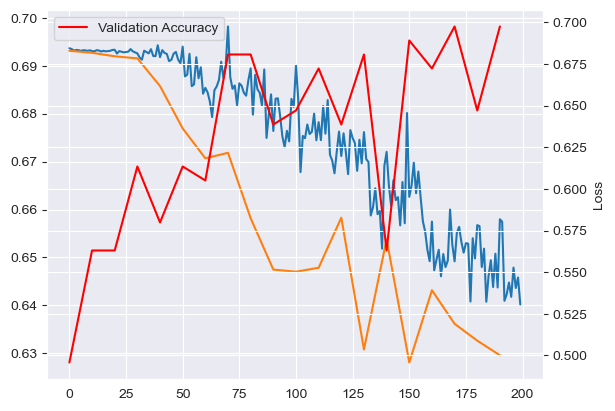

In [13]:
# Plot the training and validation loss
import matplotlib.pyplot as plt

x_ticks = range(0, 200, 10)

plt.plot(train_loss, label='Train')
plt.plot(x_ticks, val_loss, label='Validation')
# Twin the y-axis for accuracy of validation
plt.twinx()
plt.plot(x_ticks, val_accuracy, label='Validation Accuracy', color='red')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.savefig('result/loss_seizure_channels.png')

plt.show()



In [36]:
predicted_labels_total = []

time_lengths = [10, 20, 30, 40, 50, 60]



for i in range(len(results_propagation_total)):

    sample_seizure = results_propagation_total[i]['smoothed_probabilities'][50:400, :]
    
    # Feed the data to the model and get predictions
    sample_seizure = sample_seizure.T
    sample_seizure = np.expand_dims(sample_seizure, axis=1)
    
    # Convert to tensor
    sample_seizure = torch.tensor(sample_seizure, dtype=torch.float32)
    
    # Get the predictions
    predictions = model_seizure_channel(sample_seizure)
    
    # Get the predicted labels, where predicted_labels = 1 when chance is more than 80%
    predicted_labels = predictions.detach().to('cpu').numpy()
    
    predicted_labels = predicted_labels[:, 1] > 0.5
    
    predicted_labels_total.append(predicted_labels)

In [37]:
# Convert the channel from results_propagation to the y_true as 1s and 0s
gound_truth_total = []
for i in range(len(results_propagation_total)):
    y_true = np.zeros(results_propagation_total[i]['smoothed_probabilities'].shape[1])
    y_true[results_propagation_total[i]['true_seizure_channels']] = 1
    gound_truth_total.append(y_true)
    
# Convert the gound_truth_total to a single array
gound_truth_total = np.concatenate(gound_truth_total)

# Convert the predicted_labels_total to a single array
predicted_labels_total = np.concatenate(predicted_labels_total)

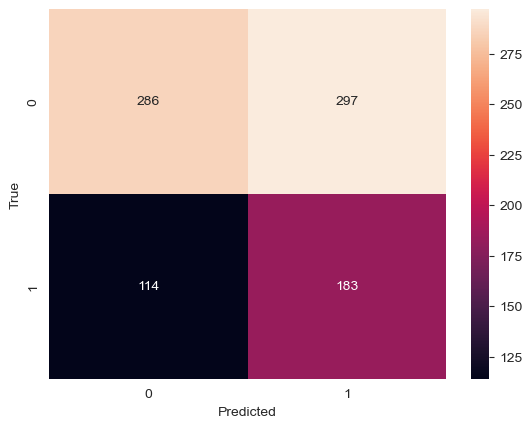

In [38]:
# Plot the confusion matrix
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

conf_matrix = confusion_matrix(gound_truth_total.flatten(), predicted_labels_total.flatten())
sns.heatmap(conf_matrix, annot=True, fmt='d')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.savefig('result/confusion_matrix_seizure_channels.png')

plt.show()


In [39]:
# Calculate the accuracy, precision, recall, and F1 score
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

accuracy = accuracy_score(gound_truth_total.flatten(), predicted_labels_total.flatten())
precision = precision_score(gound_truth_total.flatten(), predicted_labels_total.flatten())
recall = recall_score(gound_truth_total.flatten(), predicted_labels_total.flatten())
f1 = f1_score(gound_truth_total.flatten(), predicted_labels_total.flatten())

print(f'Accuracy: {accuracy}')
print(f'Precision: {precision}')
print(f'Recall: {recall}')
print(f'F1: {f1}')

Accuracy: 0.5329545454545455
Precision: 0.38125
Recall: 0.6161616161616161
F1: 0.471042471042471
